# Sommaire

* [Introduction](#introduction)
* [I) Import](#i)
* [II) Préparation des données](#ii)
* [III) Choix des modèles et des métriques de notation](#iii)
* [IV) Validation croisée](#iv)
* [V) Choix du modèle et feature importance](#v)
* [VI) ENERGYSTARScore](#vi)
* [Conclusion](#conclusion)

# Introduction <a class="anchor" id="introduction"></a>
Dans ce notebook, on poursuit et achève nos prédicitions en s'intéressant cette fois à TotalGHGEmissions. Encore une fois, l'objectif étant d'effectuer des prédictions sur des bâtiments où les relevés n'ont pas été effectués, nous les retirons du jeu de données.

Et comme dans le notebook précédent, on va d'abord développer un modèle sans ENERGYSTARScore. Mais on se servira de cette variable à la fin pour évaluer son impact sur le modèle retenu.

# I) Import <a class="anchor" id="i"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_final = pd.read_pickle('data_final.pkl')
data_final

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,ZipCode,CouncilDistrictCode,Neighborhood,Age,NumberofBuildings,NumberofFloors,...,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,Mayflower park hotel,98101,7,DOWNTOWN,89,1,12,...,NC,60,81.699997,182.500000,7.226362e+06,2003882.00,3.946027e+06,1.276453e+06,249.98,2.83
1,2,NonResidential,Hotel,Paramount Hotel,98101,7,DOWNTOWN,20,1,11,...,Restaurant,61,94.800003,176.100006,8.387933e+06,0.00,3.242851e+06,5.145082e+06,295.86,2.86
2,3,NonResidential,Hotel,5673-The Westin Seattle,98101,7,DOWNTOWN,47,1,41,...,NC,43,96.000000,241.899994,7.258702e+07,21566554.00,4.952666e+07,1.493800e+06,2089.28,2.19
3,5,NonResidential,Hotel,HOTEL MAX,98101,7,DOWNTOWN,90,1,10,...,NC,56,110.800003,216.199997,6.794584e+06,2214446.25,2.768924e+06,1.811213e+06,286.43,4.67
4,8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),98121,7,DOWNTOWN,36,1,18,...,Swimming Pool,75,114.800003,211.399994,1.417261e+07,0.00,5.368607e+06,8.803998e+06,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,50221,Nonresidential COS,Other,High Point Community Center,98126,1,DELRIDGE,34,1,1,...,NC,<NA>,51.000000,126.000000,9.320821e+05,0.00,6.323620e+05,2.997200e+05,20.33,1.11
1542,50223,Nonresidential COS,Other,International district/Chinatown CC,98104,2,DOWNTOWN,12,1,1,...,NC,<NA>,59.400002,114.199997,9.502762e+05,0.00,3.965461e+05,5.537300e+05,32.17,2.01
1543,50224,Nonresidential COS,Other,Queen Anne Pool,98119,7,MAGNOLIA / QUEEN ANNE,42,1,1,...,Swimming Pool,<NA>,438.200012,744.799988,5.765898e+06,0.00,1.792159e+06,3.973739e+06,223.54,16.99
1544,50225,Nonresidential COS,Mixed Use Property,South Park Community Center,98108,1,GREATER DUWAMISH,27,1,1,...,Other,<NA>,51.000000,105.300003,7.194712e+05,0.00,3.488702e+05,3.706010e+05,22.11,1.57


In [2]:
#Pour se débarasser de la notation scientifique de certaines colonnes
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# II) Préparation des données <a class="anchor" id="ii"></a>

In [3]:
#On commence par retirer ENERGYSTARScore, on développe le modèle sans mais on s'en servira plus tard
ess = data_final[['ENERGYSTARScore']]

#Comme dans le notebook précédent, on ajoute les informations concernant la nature et proportion des sources d'énergie utilisées
data_final['TotalEnergy'] = data_final['SteamUse(kBtu)'] + data_final['Electricity(kBtu)'] + data_final['NaturalGas(kBtu)']
data_final['SteamUse%'] = data_final['SteamUse(kBtu)'] / data_final['TotalEnergy'] * 100
data_final['Electricity%'] = data_final['Electricity(kBtu)'] / data_final['TotalEnergy'] * 100
data_final['NaturalGas%'] = data_final['NaturalGas(kBtu)'] / data_final['TotalEnergy'] * 100
data_final

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,ZipCode,CouncilDistrictCode,Neighborhood,Age,NumberofBuildings,NumberofFloors,...,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,TotalEnergy,SteamUse%,Electricity%,NaturalGas%
0,1,NonResidential,Hotel,Mayflower park hotel,98101,7,DOWNTOWN,89,1,12,...,7226362.500,2003882.000,3946027.000,1276453.000,249.980,2.830,7226362.000,27.730,54.606,17.664
1,2,NonResidential,Hotel,Paramount Hotel,98101,7,DOWNTOWN,20,1,11,...,8387933.000,0.000,3242851.000,5145082.000,295.860,2.860,8387933.000,0.000,38.661,61.339
2,3,NonResidential,Hotel,5673-The Westin Seattle,98101,7,DOWNTOWN,47,1,41,...,72587024.000,21566554.000,49526664.000,1493800.000,2089.280,2.190,72587018.000,29.711,68.231,2.058
3,5,NonResidential,Hotel,HOTEL MAX,98101,7,DOWNTOWN,90,1,10,...,6794584.000,2214446.250,2768924.000,1811213.000,286.430,4.670,6794583.250,32.591,40.752,26.657
4,8,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),98121,7,DOWNTOWN,36,1,18,...,14172606.000,0.000,5368607.000,8803998.000,505.010,2.880,14172605.000,0.000,37.880,62.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,50221,Nonresidential COS,Other,High Point Community Center,98126,1,DELRIDGE,34,1,1,...,932082.125,0.000,632362.007,299719.995,20.330,1.110,932082.002,0.000,67.844,32.156
1542,50223,Nonresidential COS,Other,International district/Chinatown CC,98104,2,DOWNTOWN,12,1,1,...,950276.188,0.000,396546.052,553729.980,32.170,2.010,950276.032,0.000,41.730,58.270
1543,50224,Nonresidential COS,Other,Queen Anne Pool,98119,7,MAGNOLIA / QUEEN ANNE,42,1,1,...,5765898.000,0.000,1792158.758,3973739.063,223.540,16.990,5765897.821,0.000,31.082,68.918
1544,50225,Nonresidential COS,Mixed Use Property,South Park Community Center,98108,1,GREATER DUWAMISH,27,1,1,...,719471.188,0.000,348870.176,370601.001,22.110,1.570,719471.177,0.000,48.490,51.510


In [4]:
#On supprime la ligne problématique qu'on a identifié dans le notebook précédent
data_final = data_final.drop(454).reset_index(drop=True)

In [5]:
#On peut enfin retirer les relevés, ainsi qu'OSEBuildingID et PropertyName qui servaient pour l'identification, mais ne seront pas utiles au modèle
df = data_final.drop(['OSEBuildingID', 'PropertyName', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
                      'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'GHGEmissionsIntensity', 'TotalEnergy'], axis=1)
df

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,TotalGHGEmissions,SteamUse%,Electricity%,NaturalGas%
0,NonResidential,Hotel,98101,7,DOWNTOWN,89,1,12,88434,0,88434,Hotel,NC,NC,249.980,27.730,54.606,17.664
1,NonResidential,Hotel,98101,7,DOWNTOWN,20,1,11,103566,15064,88502,Hotel,Parking,Restaurant,295.860,0.000,38.661,61.339
2,NonResidential,Hotel,98101,7,DOWNTOWN,47,1,41,956110,196718,759392,Hotel,NC,NC,2089.280,29.711,68.231,2.058
3,NonResidential,Hotel,98101,7,DOWNTOWN,90,1,10,61320,0,61320,Hotel,NC,NC,286.430,32.591,40.752,26.657
4,NonResidential,Hotel,98121,7,DOWNTOWN,36,1,18,175580,62000,113580,Hotel,Parking,Swimming Pool,505.010,0.000,37.880,62.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,Nonresidential COS,Other,98126,1,DELRIDGE,34,1,1,18261,0,18261,Other,NC,NC,20.330,0.000,67.844,32.156
1541,Nonresidential COS,Other,98104,2,DOWNTOWN,12,1,1,16000,0,16000,Other,NC,NC,32.170,0.000,41.730,58.270
1542,Nonresidential COS,Other,98119,7,MAGNOLIA / QUEEN ANNE,42,1,1,13157,0,13157,Other,Fitness Center/Health Club/Gym,Swimming Pool,223.540,0.000,31.082,68.918
1543,Nonresidential COS,Mixed Use Property,98108,1,GREATER DUWAMISH,27,1,1,14101,0,14101,Other,Fitness Center/Health Club/Gym,Other,22.110,0.000,48.490,51.510


In [6]:
#Avant de s'intéresser à la colinéarité des variables, on va effectuer les mêmes changements que précédemment en ce qui concerne les variables GFA
df['PropertyGFABuilding(s)'] = df['PropertyGFABuilding(s)'] / df['NumberofFloors']
df = df.rename(columns={'PropertyGFABuilding(s)': 'BuildingGFAperFloor'})
df

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,BuildingGFAperFloor,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,TotalGHGEmissions,SteamUse%,Electricity%,NaturalGas%
0,NonResidential,Hotel,98101,7,DOWNTOWN,89,1,12,88434,0,7369.500,Hotel,NC,NC,249.980,27.730,54.606,17.664
1,NonResidential,Hotel,98101,7,DOWNTOWN,20,1,11,103566,15064,8045.636,Hotel,Parking,Restaurant,295.860,0.000,38.661,61.339
2,NonResidential,Hotel,98101,7,DOWNTOWN,47,1,41,956110,196718,18521.756,Hotel,NC,NC,2089.280,29.711,68.231,2.058
3,NonResidential,Hotel,98101,7,DOWNTOWN,90,1,10,61320,0,6132.000,Hotel,NC,NC,286.430,32.591,40.752,26.657
4,NonResidential,Hotel,98121,7,DOWNTOWN,36,1,18,175580,62000,6310.000,Hotel,Parking,Swimming Pool,505.010,0.000,37.880,62.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,Nonresidential COS,Other,98126,1,DELRIDGE,34,1,1,18261,0,18261.000,Other,NC,NC,20.330,0.000,67.844,32.156
1541,Nonresidential COS,Other,98104,2,DOWNTOWN,12,1,1,16000,0,16000.000,Other,NC,NC,32.170,0.000,41.730,58.270
1542,Nonresidential COS,Other,98119,7,MAGNOLIA / QUEEN ANNE,42,1,1,13157,0,13157.000,Other,Fitness Center/Health Club/Gym,Swimming Pool,223.540,0.000,31.082,68.918
1543,Nonresidential COS,Mixed Use Property,98108,1,GREATER DUWAMISH,27,1,1,14101,0,14101.000,Other,Fitness Center/Health Club/Gym,Other,22.110,0.000,48.490,51.510


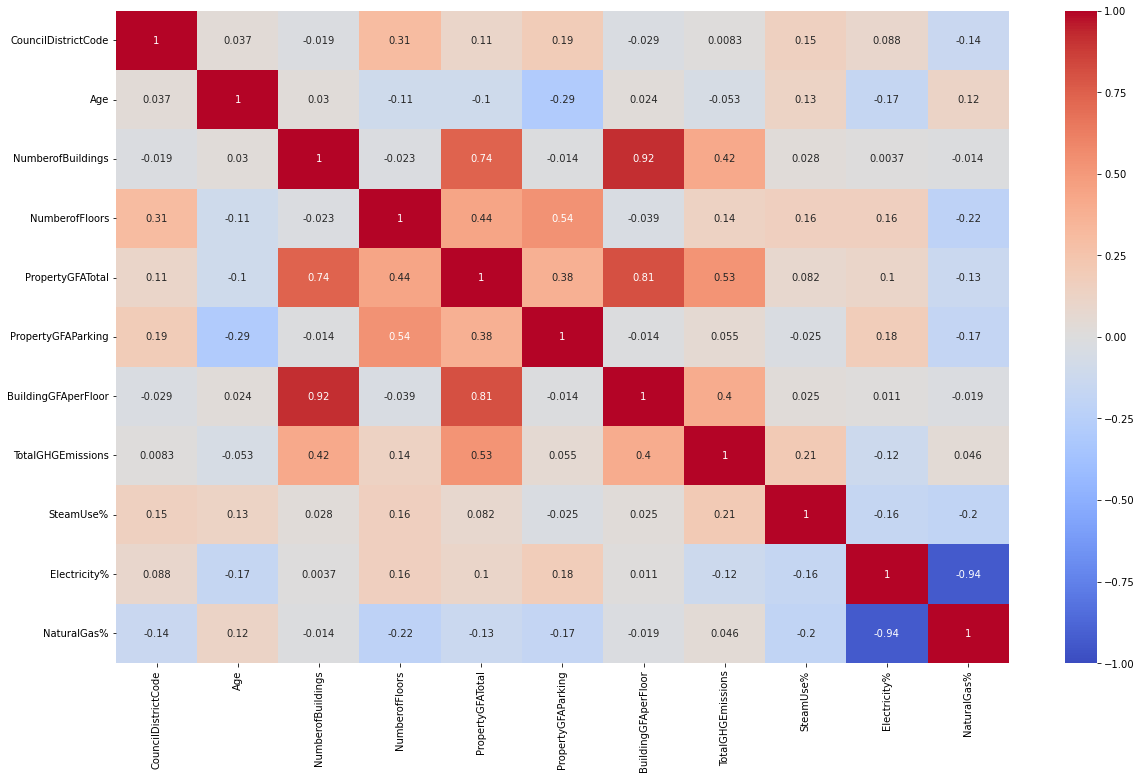

In [7]:
#Maintenant on vérifie
corr_matrix = df.select_dtypes(include=['int', 'float']).corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1)
plt.show()

In [8]:
#Même observation que tout à l'heure, du progrès malgré quelques paires de variables fortement liées
#Il ne m'a pas semblé y avoir de soucis liés à la colinéarité des variables à partir de la là dans le notebook précédent donc je suis confiant
#On va désormais séparer les variables qualitatives et quantitatives
#On transforme à nouveau CouncilDistrictCode en type object, car c'est plus simple pour les encoders
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].astype(object)

var_quali = df.select_dtypes(include=['object']).columns
var_quali

Index(['BuildingType', 'PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode',
       'Neighborhood', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'],
      dtype='object')

In [9]:
var_quanti = df.select_dtypes(include=['int','float']).columns
var_quanti = var_quanti.delete([-4]) #On retire la cible TotalGHGEmissions
var_quanti

Index(['Age', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'BuildingGFAperFloor', 'SteamUse%',
       'Electricity%', 'NaturalGas%'],
      dtype='object')

In [10]:
#On va tester plusieurs encoders pour nos variables qualitatives : OneHot, Binary et Target
#Ce sera StandardScaler pour les variables quantitatives dans tous les cas
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import BinaryEncoder, TargetEncoder
from sklearn.compose import make_column_transformer

preprocessor_oh = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False), var_quali),
                                          (StandardScaler(), var_quanti))

preprocessor_b = make_column_transformer((BinaryEncoder(), var_quali), 
                                         (StandardScaler(), var_quanti))

preprocessor_t = make_column_transformer((TargetEncoder(), var_quali),
                                         (StandardScaler(), var_quanti))

In [11]:
#On définit X et y
X = df.drop('TotalGHGEmissions', axis=1)
y = df['TotalGHGEmissions']

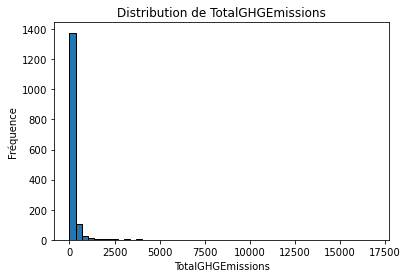

In [12]:
#On s'intéresse à la distribution de y
plt.hist(y, bins=50, edgecolor='black')
plt.title('Distribution de TotalGHGEmissions')
plt.xlabel('TotalGHGEmissions')
plt.ylabel('Fréquence')
plt.show()

In [13]:
#On retrouve une distribution similaire à celle de la cible précédente, on retente donc un passage au log
y = np.log1p(y)

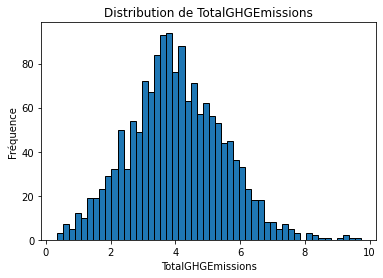

In [14]:
#Même démarche
plt.hist(y, bins=50, edgecolor='black')
plt.title('Distribution de TotalGHGEmissions')
plt.xlabel('TotalGHGEmissions')
plt.ylabel('Fréquence')
plt.show()

In [15]:
#Le passage au log a permis de réduire les valeurs extrêmes ainsi que d'aboutir à une distribution plus proche de la distribution normale
#On sépare jeu de test et jeu d'entraînement
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
#Transformation des X
X_train_oh = preprocessor_oh.fit_transform(X_train)
X_test_oh = preprocessor_oh.transform(X_test)

X_train_b = preprocessor_b.fit_transform(X_train)
X_test_b = preprocessor_b.transform(X_test)

X_train_t = preprocessor_t.fit_transform(X_train, y_train)
X_test_t = preprocessor_t.transform(X_test)

#Transformation des y
scalery = StandardScaler()
y_train_scaled = scalery.fit_transform(y_train.values.reshape(-1, 1)).flatten() #Pour un résultat unidimensionnel
y_test_scaled = scalery.transform(y_test.values.reshape(-1, 1)).flatten() #Idem

In [16]:
#On voit que les dimensions ne sont pas les mêmes d'un encodage à l'autre
print(X_train_oh.shape)
print(X_train_b.shape)
print(X_train_t.shape)

(1236, 119)
(1236, 42)
(1236, 17)


In [17]:
#Par curiosité
noms_features = np.concatenate((var_quali, var_quanti))
pd.DataFrame(X_train_t, columns=noms_features)

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,BuildingGFAperFloor,SteamUse%,Electricity%,NaturalGas%
0,3.998,4.952,4.269,3.840,4.017,4.861,4.583,4.080,-0.249,-0.073,-0.499,0.055,0.478,0.244,-0.237,0.285,-0.202
1,3.998,3.303,3.510,3.526,3.495,3.933,4.209,3.956,0.363,-0.073,-0.499,-0.093,-0.319,0.197,-0.237,-0.294,0.372
2,3.998,3.145,3.510,3.526,3.495,3.177,3.871,3.956,1.893,-0.073,-0.351,-0.219,-0.319,-0.054,-0.237,-1.818,1.881
3,3.998,4.370,4.087,4.381,4.438,4.301,4.148,3.956,-1.137,-0.073,-0.351,-0.117,1.154,-0.113,-0.237,-1.416,1.483
4,3.998,3.145,3.358,4.097,3.495,3.177,3.871,3.956,-0.341,-0.073,-0.499,-0.268,-0.319,-0.017,-0.237,-1.983,2.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,3.998,3.298,3.510,3.526,3.495,3.297,3.765,3.956,0.240,-0.073,-0.499,-0.268,-0.319,-0.017,-0.237,-0.035,0.115
1232,3.998,4.370,4.454,4.408,3.880,4.354,4.583,3.956,-0.556,-0.073,-0.204,-0.285,-0.319,-0.112,-0.237,1.146,-1.055
1233,3.998,4.559,3.901,4.408,3.880,4.675,3.765,4.080,-0.005,-0.073,-0.351,-0.273,-0.319,-0.086,-0.237,-1.181,1.250
1234,3.998,3.303,4.223,4.408,4.501,3.933,4.583,3.956,-0.709,-0.073,0.238,-0.155,-0.319,-0.105,-0.237,1.146,-1.055


In [18]:
#Dernière manipulation avant la suite, il faut centrer et réduire les variables qualitatives qui ont subit l'encodage Target (les 8 premières colonnes donc)
scalerx = StandardScaler()
X_train_t[:, :8] = scalerx.fit_transform(X_train_t[:, :8])
X_test_t[:, :8] = scalerx.transform(X_test_t[:, :8])

In [19]:
#On vérifie
pd.DataFrame(X_train_t, columns=noms_features)

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,BuildingGFAperFloor,SteamUse%,Electricity%,NaturalGas%
0,-0.252,1.322,0.468,-0.603,-0.100,1.553,1.745,0.201,-0.249,-0.073,-0.499,0.055,0.478,0.244,-0.237,0.285,-0.202
1,-0.252,-1.006,-1.201,-1.491,-1.545,-0.136,0.520,-0.384,0.363,-0.073,-0.499,-0.093,-0.319,0.197,-0.237,-0.294,0.372
2,-0.252,-1.228,-1.201,-1.491,-1.545,-1.511,-0.588,-0.384,1.893,-0.073,-0.351,-0.219,-0.319,-0.054,-0.237,-1.818,1.881
3,-0.252,0.501,0.069,0.927,1.063,0.534,0.320,-0.384,-1.137,-0.073,-0.351,-0.117,1.154,-0.113,-0.237,-1.416,1.483
4,-0.252,-1.228,-1.534,0.124,-1.545,-1.511,-0.588,-0.384,-0.341,-0.073,-0.499,-0.268,-0.319,-0.017,-0.237,-1.983,2.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,-0.252,-1.012,-1.201,-1.491,-1.545,-1.293,-0.933,-0.384,0.240,-0.073,-0.499,-0.268,-0.319,-0.017,-0.237,-0.035,0.115
1232,-0.252,0.501,0.874,1.005,-0.480,0.630,1.745,-0.384,-0.556,-0.073,-0.204,-0.285,-0.319,-0.112,-0.237,1.146,-1.055
1233,-0.252,0.768,-0.342,1.005,-0.480,1.215,-0.933,0.201,-0.005,-0.073,-0.351,-0.273,-0.319,-0.086,-0.237,-1.181,1.250
1234,-0.252,-1.006,0.365,1.005,1.238,-0.136,1.745,-0.384,-0.709,-0.073,0.238,-0.155,-0.319,-0.105,-0.237,1.146,-1.055


# III) Choix des modèles et des métriques de notation <a class="anchor" id="iii"></a>

In [20]:
#Les modèles qu'on va tester
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
    
modèles = {'DummyRegressor' : DummyRegressor(strategy="median"), #Moins sensible aux outliers que "mean"
           'Ridge' : Ridge(),
           'Lasso' : Lasso(),
           'ElasticNet' : ElasticNet(),
           'DecisionTree' : DecisionTreeRegressor(random_state=42),
           'SVR' : SVR(),
           'KernelRidge' : KernelRidge(),
           'RandomForestRegressor' : RandomForestRegressor(random_state=42),
           'XGBRegressor' : XGBRegressor()}

In [21]:
#On commence par tester ces métriques pour chaque modèle et sur chaque encoder sans toucher aux hyperparamètres
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Pour enregistrer les résultats, on commence par l'encodage OneHot
résultats_oh = []

#Une boucle par modèle
for nom_modèle, modèle in modèles.items():
        
    #On fit
    modèle.fit(X_train_oh, y_train_scaled)
    y_pred = modèle.predict(X_test_oh)
    
    #Evaluation des performances
    print(f"Performance {nom_modèle} :")
    MAE = mean_absolute_error(y_test_scaled, y_pred)
    MSE = mean_squared_error(y_test_scaled, y_pred)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test_scaled, y_pred, multioutput="variance_weighted")
    print("MAE =", MAE)        
    print("MSE =", MSE)
    print("RMSE =", RMSE)
    print("R² =", R2)
    print("\n")

    #On ajoute les résultats à la liste
    résultats_oh.append([nom_modèle, MAE, MSE, RMSE, R2])

Performance DummyRegressor :
MAE = 0.754671103878899
MSE = 0.9862905667820728
RMSE = 0.9931216273861287
R² = -0.00031560270856578754


Performance Ridge :
MAE = 0.4269838517381193
MSE = 0.32272175623775184
RMSE = 0.568086046508583
R² = 0.6726891456019943


Performance Lasso :
MAE = 0.761371577205839
MSE = 0.991292660472072
RMSE = 0.9956368115292202
R² = -0.005388826090029664


Performance ElasticNet :
MAE = 0.761371577205839
MSE = 0.991292660472072
RMSE = 0.9956368115292202
R² = -0.005388826090029664


Performance DecisionTree :
MAE = 0.4782030407565993
MSE = 0.39907966068306694
RMSE = 0.63172752091631
R² = 0.5952454329889996


Performance SVR :
MAE = 0.33015501739699754
MSE = 0.2057620487055951
RMSE = 0.4536100183038235
R² = 0.7913120182858188


Performance KernelRidge :
MAE = 0.4271645488977483
MSE = 0.32278246183299414
RMSE = 0.5681394739260722
R² = 0.6726275767741683


Performance RandomForestRegressor :
MAE = 0.3496603085638615
MSE = 0.22452707848130707
RMSE = 0.4738428837508347
R

In [22]:
#Pour y voir plus clair
résultats_oh = pd.DataFrame(résultats_oh, columns=['Modèle', 'MAE', 'MSE', 'RMSE', 'R²'])
résultats_oh

,Modèle,MAE,MSE,RMSE,R²
0,DummyRegressor,0.755,0.986,0.993,-0.000
1,Ridge,0.427,0.323,0.568,0.673
2,Lasso,0.761,0.991,0.996,-0.005
3,ElasticNet,0.761,0.991,0.996,-0.005
4,DecisionTree,0.478,0.399,0.632,0.595
5,SVR,0.330,0.206,0.454,0.791
6,KernelRidge,0.427,0.323,0.568,0.673
7,RandomForestRegressor,0.350,0.225,0.474,0.772
8,XGBRegressor,0.338,0.227,0.476,0.770


In [23]:
#Même chose avec l'encodage binaire
résultats_b = []

#Une boucle par modèle
for nom_modèle, modèle in modèles.items():
        
    #On fit
    modèle.fit(X_train_b, y_train_scaled)
    y_pred = modèle.predict(X_test_b)
    
    #Evaluation des performances
    print(f"Performance {nom_modèle} :")
    MAE = mean_absolute_error(y_test_scaled, y_pred)
    MSE = mean_squared_error(y_test_scaled, y_pred)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test_scaled, y_pred, multioutput="variance_weighted")
    print("MAE =", MAE)        
    print("MSE =", MSE)
    print("RMSE =", RMSE)
    print("R² =", R2)
    print("\n")

    #On ajoute les résultats à la liste
    résultats_b.append([nom_modèle, MAE, MSE, RMSE, R2])

Performance DummyRegressor :
MAE = 0.754671103878899
MSE = 0.9862905667820728
RMSE = 0.9931216273861287
R² = -0.00031560270856578754


Performance Ridge :
MAE = 0.4790046087342761
MSE = 0.3982724400565635
RMSE = 0.631088298145801
R² = 0.5960641322797716


Performance Lasso :
MAE = 0.761371577205839
MSE = 0.991292660472072
RMSE = 0.9956368115292202
R² = -0.005388826090029664


Performance ElasticNet :
MAE = 0.761371577205839
MSE = 0.991292660472072
RMSE = 0.9956368115292202
R² = -0.005388826090029664


Performance DecisionTree :
MAE = 0.5184480507488443
MSE = 0.510680644944508
RMSE = 0.7146192307407547
R² = 0.48205748453423225


Performance SVR :
MAE = 0.36250391683341904
MSE = 0.23661384454092754
RMSE = 0.48642969126167407
R² = 0.7600215104121069


Performance KernelRidge :
MAE = 0.477543277372771
MSE = 0.3951385692673773
RMSE = 0.6286004846222896
R² = 0.5992425666609535


Performance RandomForestRegressor :
MAE = 0.36395864254819066
MSE = 0.2440907624373154
RMSE = 0.4940554244589522
R

In [24]:
#Pour y voir plus clair
résultats_b = pd.DataFrame(résultats_b, columns=['Modèle', 'MAE', 'MSE', 'RMSE', 'R²'])
résultats_b

,Modèle,MAE,MSE,RMSE,R²
0,DummyRegressor,0.755,0.986,0.993,-0.000
1,Ridge,0.479,0.398,0.631,0.596
2,Lasso,0.761,0.991,0.996,-0.005
3,ElasticNet,0.761,0.991,0.996,-0.005
4,DecisionTree,0.518,0.511,0.715,0.482
5,SVR,0.363,0.237,0.486,0.760
6,KernelRidge,0.478,0.395,0.629,0.599
7,RandomForestRegressor,0.364,0.244,0.494,0.752
8,XGBRegressor,0.368,0.249,0.499,0.748


In [25]:
#Et enfin, l'encodage Target
résultats_t = []

#Une boucle par modèle
for nom_modèle, modèle in modèles.items():
        
    #On fit
    modèle.fit(X_train_t, y_train_scaled)
    y_pred = modèle.predict(X_test_t)
    
    #Evaluation des performances
    print(f"Performance {nom_modèle} :")
    MAE = mean_absolute_error(y_test_scaled, y_pred)
    MSE = mean_squared_error(y_test_scaled, y_pred)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test_scaled, y_pred, multioutput="variance_weighted")
    print("MAE =", MAE)        
    print("MSE =", MSE)
    print("RMSE =", RMSE)
    print("R² =", R2)
    print("\n")

    #On ajoute les résultats à la liste
    résultats_t.append([nom_modèle, MAE, MSE, RMSE, R2])

Performance DummyRegressor :
MAE = 0.754671103878899
MSE = 0.9862905667820728
RMSE = 0.9931216273861287
R² = -0.00031560270856578754


Performance Ridge :
MAE = 0.45109022238138674
MSE = 0.35047127070650125
RMSE = 0.592006140767561
R² = 0.6445450334857821


Performance Lasso :
MAE = 0.761371577205839
MSE = 0.991292660472072
RMSE = 0.9956368115292202
R² = -0.005388826090029664


Performance ElasticNet :
MAE = 0.7506187626770534
MSE = 0.9656065913090113
RMSE = 0.9826528335628057
R² = 0.02066249856158109


Performance DecisionTree :
MAE = 0.45939232828067905
MSE = 0.37095215958483385
RMSE = 0.6090584205023635
R² = 0.6237729066984605


Performance SVR :
MAE = 0.35548181865235545
MSE = 0.24044614028653205
RMSE = 0.4903530771663741
R² = 0.7561347194829092


Performance KernelRidge :
MAE = 0.451090222381387
MSE = 0.3504712707065023
RMSE = 0.5920061407675619
R² = 0.6445450334857811


Performance RandomForestRegressor :
MAE = 0.3331806202553779
MSE = 0.21729088665809276
RMSE = 0.466144705706385

In [26]:
#Pour y voir plus clair
résultats_t = pd.DataFrame(résultats_t, columns=['Modèle', 'MAE', 'MSE', 'RMSE', 'R²'])
résultats_t

,Modèle,MAE,MSE,RMSE,R²
0,DummyRegressor,0.755,0.986,0.993,-0.000
1,Ridge,0.451,0.350,0.592,0.645
2,Lasso,0.761,0.991,0.996,-0.005
3,ElasticNet,0.751,0.966,0.983,0.021
4,DecisionTree,0.459,0.371,0.609,0.624
5,SVR,0.355,0.240,0.490,0.756
6,KernelRidge,0.451,0.350,0.592,0.645
7,RandomForestRegressor,0.333,0.217,0.466,0.780
8,XGBRegressor,0.345,0.230,0.480,0.767


In [27]:
#On va s'intéresser à la feature importance
#On le fait à partir de X_train_t car Target est le seul encodage qui conserve les features du df de base
from sklearn.inspection import permutation_importance

#Pour stocker les résultats de la feature importance
importances = {}

#Une boucle par modèle
for nom_modèle, modèle in modèles.items():

    #On fit
    modèle.fit(X_train_t, y_train_scaled)
    
    #Calcul de la feature importance
    résultat = permutation_importance(modèle, X_test_t, y_test_scaled, n_repeats=10, random_state=42, n_jobs=-1)
    importances[nom_modèle] = résultat.importances_mean

#Résultats
for nom_modèle, importance in importances.items():
    print(f"Feature importance pour {nom_modèle}:")
    for nom_feature, imp in zip(noms_features, importance):
        print(f"{nom_feature} : {imp}")
    print()

Feature importance pour DummyRegressor:
BuildingType : 0.0
PrimaryPropertyType : 0.0
ZipCode : 0.0
CouncilDistrictCode : 0.0
Neighborhood : 0.0
LargestPropertyUseType : 0.0
SecondLargestPropertyUseType : 0.0
ThirdLargestPropertyUseType : 0.0
Age : 0.0
NumberofBuildings : 0.0
NumberofFloors : 0.0
PropertyGFATotal : 0.0
PropertyGFAParking : 0.0
BuildingGFAperFloor : 0.0
SteamUse% : 0.0
Electricity% : 0.0
NaturalGas% : 0.0

Feature importance pour Ridge:
BuildingType : 0.0014102501842810367
PrimaryPropertyType : 0.08106239217903972
ZipCode : 0.0200197880620561
CouncilDistrictCode : 0.0006964873326329668
Neighborhood : 6.496979675247871e-05
LargestPropertyUseType : 0.03964827149654952
SecondLargestPropertyUseType : 0.00686535864713943
ThirdLargestPropertyUseType : 0.001514443063487103
Age : 0.0350431941058781
NumberofBuildings : -0.0009564481652654222
NumberofFloors : -0.0062199642165823524
PropertyGFATotal : 0.5073352231866066
PropertyGFAParking : 0.0018818512636821771
BuildingGFAperFloor

In [28]:
importances = pd.DataFrame(importances, index=noms_features)
importances

,DummyRegressor,Ridge,Lasso,ElasticNet,DecisionTree,SVR,KernelRidge,RandomForestRegressor,XGBRegressor
BuildingType,0.000,0.001,0.000,0.000,0.002,0.017,0.001,0.001,0.002
PrimaryPropertyType,0.000,0.081,0.000,0.027,0.042,0.059,0.081,0.029,0.031
ZipCode,0.000,0.020,0.000,0.000,0.020,0.018,0.020,0.006,0.009
CouncilDistrictCode,0.000,0.001,0.000,0.000,0.006,0.001,0.001,0.000,0.002
Neighborhood,0.000,0.000,0.000,0.000,-0.001,0.008,0.000,0.002,0.008
LargestPropertyUseType,0.000,0.040,0.000,0.000,0.121,0.122,0.040,0.068,0.100
SecondLargestPropertyUseType,0.000,0.007,0.000,0.000,0.010,0.020,0.007,0.000,0.001
ThirdLargestPropertyUseType,0.000,0.002,0.000,0.000,0.013,0.022,0.002,0.002,0.003
Age,0.000,0.035,0.000,0.000,0.052,0.027,0.035,0.003,0.013
NumberofBuildings,0.000,-0.001,0.000,0.000,-0.001,0.000,-0.001,0.000,-0.000


In [29]:
#PropertyGFATotal a une nouvelle fois l'air de se démarquer dans certains modèles, mais Electricity% également ce qui n'était pas le cas précédemment
#On fait un df comparatif pour décider quel encoder utiliser
#Les métriques
métriques = ['MAE', 'MSE', 'RMSE', 'R²']

#Nouveau df vide
best_encoder = pd.DataFrame(columns=['Modèle'] + métriques)

#On remplit avec les meilleurs scores pour chaque métrique
for modèle in résultats_t['Modèle'].unique():
    row = {'Modèle' : modèle}
    for métrique in métriques:
        valeur_t = résultats_t.loc[résultats_t['Modèle'] == modèle, métrique].values[0]
        valeur_b = résultats_b.loc[résultats_b['Modèle'] == modèle, métrique].values[0]
        valeur_oh = résultats_oh.loc[résultats_oh['Modèle'] == modèle, métrique].values[0]
        
        #Comparaison des scores, R² est à part car il est meilleur quand il est plus élevé
        if métrique == 'R²':
            if valeur_t >= valeur_b and valeur_t >= valeur_oh:
                row[métrique] = 'T'
            elif valeur_b >= valeur_t and valeur_b >= valeur_oh:
                row[métrique] = 'B'
            else:
                row[métrique] = 'OH'
        else:
            if valeur_t <= valeur_b and valeur_t <= valeur_oh:
                row[métrique] = 'T'
            elif valeur_b <= valeur_t and valeur_b <= valeur_oh:
                row[métrique] = 'B'
            else:
                row[métrique] = 'OH'
    
    #On ajoute la ligne au df
    best_encoder = pd.concat([best_encoder, pd.DataFrame([row])], ignore_index=True)
                                  
best_encoder

,Modèle,MAE,MSE,RMSE,R²
0,DummyRegressor,T,T,T,T
1,Ridge,OH,OH,OH,OH
2,Lasso,T,T,T,T
3,ElasticNet,T,T,T,T
4,DecisionTree,T,T,T,T
5,SVR,OH,OH,OH,OH
6,KernelRidge,OH,OH,OH,OH
7,RandomForestRegressor,T,T,T,T
8,XGBRegressor,OH,OH,OH,OH


Etant donné les scores une nouvelle fois catastrophiques de DummyRegressor, Lasso et ElasticNet, on va encore privilégier l'encoder OneHot.
# IV) Validation croisée <a class="anchor" id="iv"></a>

Best params : {'alpha': 500, 'solver': 'auto'}
Best estimator : Ridge(alpha=500)
Temps d'ajustement : 0.0033915042877197266 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.537927919428292
Test MSE : 0.4579183312320622
Test RMSE : 0.6766966316098095
Test R² : 0.5420816687679377


Métriques à partir des prédictions :
Test MAE : 0.5038111245004846
Test MSE : 0.4507208671954392
Test RMSE : 0.6713574809261004
Test R² : 0.5428698893542654


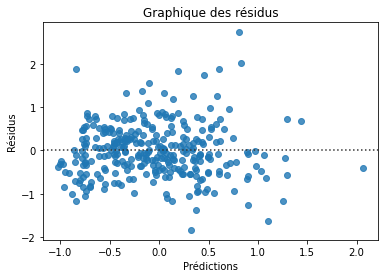

In [30]:
#On va faire une validation croisée pour affiner les hyperparamètres de chaque modèle tout en évitant l'overfitting
#DummyRegressor est exclu de cette phase
from sklearn.model_selection import GridSearchCV

#Pour enregistrer les résultats
résultats_gridSearch = []

#On utilise "neg" car ce sont des métriques que GridSearch va chercher à maximiser, or nous cherchons à minimiser les erreurs donc le passage au négatif contourne ce problème
scoring = {'MSE' : 'neg_mean_squared_error',
           'MAE' : 'neg_mean_absolute_error',
           'RMSE' : 'neg_root_mean_squared_error',
           'R²' : 'r2'}

#On commence par Ridge()
params_Ridge = {'alpha' : [450, 500, 550], #J'ai un peu tâtonné pour trouver la meilleure valeur 
                'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

#Le modèle
Ridge_gridSearch = GridSearchCV(Ridge(), params_Ridge, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
Ridge_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_Ridge = Ridge_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_Ridge = Ridge_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = Ridge_gridSearch.cv_results_
best_index = Ridge_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_Ridge)
train_MSE = mean_squared_error(y_train_scaled, y_train_Ridge)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_Ridge)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_Ridge)
test_MSE = mean_squared_error(y_test_scaled, y_test_Ridge)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_Ridge)

#Impression des meilleurs paramètres
print("Best params :", Ridge_gridSearch.best_params_)
print("Best estimator :", Ridge_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['Ridge', Ridge_gridSearch.best_params_, Ridge_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_Ridge
sns.residplot(x=y_test_Ridge, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

Best params : {'alpha': 0.1, 'max_iter': 1000, 'tol': 0.0001}
Best estimator : Lasso(alpha=0.1)
Temps d'ajustement : 0.009773778915405273 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.5925551967983015
Test MSE : 0.5445295892465151
Test RMSE : 0.737922481868194
Test R² : 0.45547041075348493


Métriques à partir des prédictions :
Test MAE : 0.5641735899579764
Test MSE : 0.5401585176771634
Test RMSE : 0.7349547725385307
Test R² : 0.4521604369275223


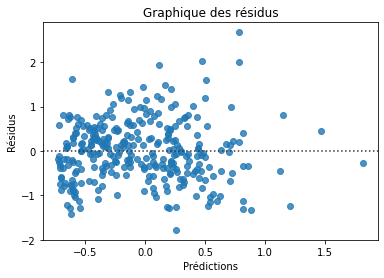

In [31]:
#On enchaîne avec Lasso()
params_Lasso = {'alpha' : [0.001, 0.01, 0.1, 1, 10],
                'tol' : [0.000001, 0.00001, 0.0001], 
                'max_iter' : [1000, 10000]}

#Le modèle
Lasso_gridSearch = GridSearchCV(Lasso(), params_Lasso, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
Lasso_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_Lasso = Lasso_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_Lasso = Lasso_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = Lasso_gridSearch.cv_results_
best_index = Lasso_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_Lasso)
train_MSE = mean_squared_error(y_train_scaled, y_train_Lasso)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_Lasso)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_Lasso)
test_MSE = mean_squared_error(y_test_scaled, y_test_Lasso)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_Lasso)

#Impression des meilleurs paramètres
print("Best params :", Lasso_gridSearch.best_params_)
print("Best estimator :", Lasso_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['Lasso', Lasso_gridSearch.best_params_, Lasso_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_Lasso
sns.residplot(x=y_test_Lasso, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

Best params : {'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 10000, 'tol': 1e-08}
Best estimator : ElasticNet(alpha=0.1, max_iter=10000, tol=1e-08)
Temps d'ajustement : 0.00702199935913086 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.5734791561217403
Test MSE : 0.5102499449143735
Test RMSE : 0.7143178178614709
Test R² : 0.4897500550856265


Métriques à partir des prédictions :
Test MAE : 0.5382172369397742
Test MSE : 0.49579032024772934
Test RMSE : 0.7041237961095544
Test R² : 0.4971595494076516


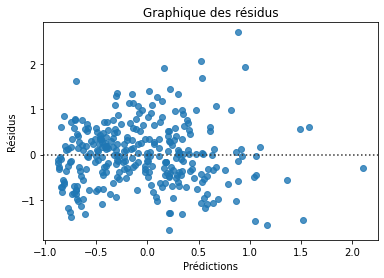

In [32]:
#On enchaîne avec ElasticNet()
params_EN = {'alpha' : [0.01, 0.1, 1],
             'l1_ratio' : np.arange(0.1, 1.1, 0.1), #Fourchette de 0.1 à 1 par pas de 0.1, problème de convergence pour l1_ratio = 0
             'tol' : [0.00000001, 0.0000001, 0.000001],
             'max_iter' : [10000]}

#Le modèle
EN_gridSearch = GridSearchCV(ElasticNet(), params_EN, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
EN_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_EN = EN_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_EN = EN_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = EN_gridSearch.cv_results_
best_index = EN_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_EN)
train_MSE = mean_squared_error(y_train_scaled, y_train_EN)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_EN)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_EN)
test_MSE = mean_squared_error(y_test_scaled, y_test_EN)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_EN)

#Impression des meilleurs paramètres
print("Best params :", EN_gridSearch.best_params_)
print("Best estimator :", EN_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['ElasticNet', EN_gridSearch.best_params_, EN_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_EN
sns.residplot(x=y_test_EN, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

Best params : {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 20}
Best estimator : DecisionTreeRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=20,
                      random_state=42)
Temps d'ajustement : 0.008377456665039062 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.3165111233843741
Test MSE : 0.1680213033959043
Test RMSE : 0.4099040172966158
Test R² : 0.8319786966040957


Métriques à partir des prédictions :
Test MAE : 0.41351413101821444
Test MSE : 0.29303206806763754
Test RMSE : 0.541324364930711
Test R² : 0.702801020658262


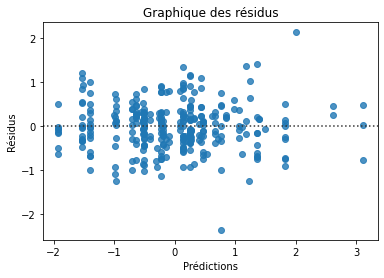

In [33]:
#On enchaîne avec DecisionTreeRegressor()
params_DTR = {'max_depth' : [6, 7, 8],
              'min_samples_split' : [19, 20, 21],
              'min_samples_leaf' : [1, 2, 3, 4, 5],
              'max_features' : ['sqrt', 'log2', None]}

#Le modèle
DTR_gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=42), params_DTR, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
DTR_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_DTR = DTR_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_DTR = DTR_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = DTR_gridSearch.cv_results_
best_index = DTR_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_DTR)
train_MSE = mean_squared_error(y_train_scaled, y_train_DTR)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_DTR)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_DTR)
test_MSE = mean_squared_error(y_test_scaled, y_test_DTR)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_DTR)

#Impression des meilleurs paramètres
print("Best params :", DTR_gridSearch.best_params_)
print("Best estimator :", DTR_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['DecisionTree', DTR_gridSearch.best_params_, DTR_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_DTR
sns.residplot(x=y_test_DTR, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

In [45]:
#On enchaîne avec SVR() et on change de stratégie
#Ce modèle est long à entraîner alors pour optimiser notre recherche des meilleurs hyperparamtètres, on va utiliser RandomizedSearchCV
#On pourra ainsi balayer assez large, et on affinera par la suite
from sklearn.model_selection import RandomizedSearchCV

params_randomSVR = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 
                    'C' : [0.1, 1, 10, 100],  
                    'gamma' : ['scale', 'auto', 0.001, 0.01, 0.1],  
                    'epsilon' : np.arange(0.1, 1.1, 0.1), #Fourchette de 0.1 à 1 par pas de 0.1
                    'degree' : [1, 2, 3]}

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomSVR_gridSearch = RandomizedSearchCV(SVR(), params_randomSVR, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomSVR_gridSearch.fit(X_train_oh, y_train_scaled)

    #Impression des meilleurs paramètres
    print("Best params :", randomSVR_gridSearch.best_params_)
    print("\n")

Best params : {'kernel': 'rbf', 'gamma': 0.01, 'epsilon': 0.2, 'degree': 2, 'C': 100}


Best params : {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.2, 'degree': 2, 'C': 10}


Best params : {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.7000000000000001, 'degree': 1, 'C': 100}


Best params : {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.30000000000000004, 'degree': 1, 'C': 10}


Best params : {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.30000000000000004, 'degree': 1, 'C': 1}




Best params : {'C': 1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
Best estimator : SVR(C=1, epsilon=0.2)
Temps d'ajustement : 0.08816409111022949 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.27470323682968495
Test MSE : 0.13173992824604727
Test RMSE : 0.3629599540528504
Test R² : 0.8682600717539527


Métriques à partir des prédictions :
Test MAE : 0.33155371116461096
Test MSE : 0.20547926061839006
Test RMSE : 0.45329820275221705
Test R² : 0.7915988276150556


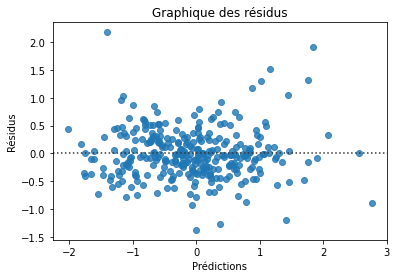

In [34]:
#Manifestement rbf est le meilleur noyau, donc degree est inutile, on affine la recherche à partir des best_params de RandomizedSearchCV
params_SVR = {'kernel' : ['rbf'], 
              'C' : [1, 10, 100],
              'gamma' : ['scale'],  
              'epsilon' : np.arange(0.2, 0.8, 0.1)} #Fourchette de 0.2 à 0.7 par pas de 0.1

#Le modèle
SVR_gridSearch = GridSearchCV(SVR(), params_SVR, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
SVR_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_SVR = SVR_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_SVR = SVR_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = SVR_gridSearch.cv_results_
best_index = SVR_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_SVR)
train_MSE = mean_squared_error(y_train_scaled, y_train_SVR)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_SVR)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_SVR)
test_MSE = mean_squared_error(y_test_scaled, y_test_SVR)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_SVR)

#Impression des meilleurs paramètres
print("Best params :", SVR_gridSearch.best_params_)
print("Best estimator :", SVR_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['SVR', SVR_gridSearch.best_params_, SVR_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_SVR
sns.residplot(x=y_test_SVR, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

Best params : {'alpha': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
Best estimator : KernelRidge(alpha=0.01, gamma=0.01, kernel='rbf')
Temps d'ajustement : 0.07879958152770997 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.23006946814077173
Test MSE : 0.094247934066707
Test RMSE : 0.30699826394738294
Test R² : 0.9057520659332929


Métriques à partir des prédictions :
Test MAE : 0.32991121991974337
Test MSE : 0.20392090797076295
Test RMSE : 0.45157602678924724
Test R² : 0.7931793400121574


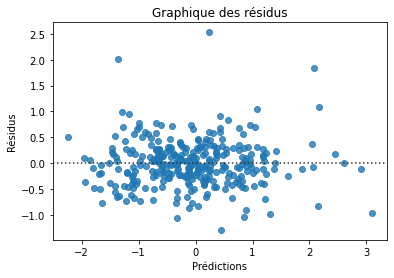

In [35]:
#On enchaîne avec KernelRidge(), plus rapide à entraîner donc on peut se passer de RandomizedSearchCV
#J'ai testé différentes valeurs de degree également, mais comme "rbf" est le kernel le plus performant il n'a pas d'impact
#Je l'ai donc retiré pour accélérer le temps de calcul
params_KR = {'alpha' : [0.001, 0.01, 1], 
             'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
             'gamma' : [0.001, 0.01, 0.1]}

#Le modèle
KR_gridSearch = GridSearchCV(KernelRidge(), params_KR, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
KR_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_KR = KR_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_KR = KR_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = KR_gridSearch.cv_results_
best_index = KR_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_KR)
train_MSE = mean_squared_error(y_train_scaled, y_train_KR)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_KR)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_KR)
test_MSE = mean_squared_error(y_test_scaled, y_test_KR)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_KR)

#Impression des meilleurs paramètres
print("Best params :", KR_gridSearch.best_params_)
print("Best estimator :", KR_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['KernelRidge', KR_gridSearch.best_params_, KR_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_KR
sns.residplot(x=y_test_KR, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

In [60]:
#On enchaîne avec RandomForestRegressor() et on repasse sur la stratégie RandomizedSearchCV
#Le nombre d'hyperparamètres à tester étant plus élevé, le temps de calcul augmente également
params_randomRFR = {'n_estimators' : np.arange(50, 501, 50), #Fourchette de 50 à 500 par pas de 50
                    'max_features' : ['sqrt', 'log2', None],
                    'max_depth' : np.arange(3, 16, 1), #Fourchette de 3 à 15 par pas de 1
                    'min_samples_split' : np.arange(2, 11, 1), #Fourchette de 2 à 10 par pas de 1
                    'min_samples_leaf' : np.arange(1, 6, 1)} #Fourchette de 1 à 5 par pas de 1

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomRFR_gridSearch = RandomizedSearchCV(RandomForestRegressor(random_state=42), params_randomRFR, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomRFR_gridSearch.fit(X_train_oh, y_train_scaled)

    #Impression des meilleurs paramètres
    print("Best params :", randomRFR_gridSearch.best_params_)
    print("\n")

Best params : {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 12}


Best params : {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}


Best params : {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 9}


Best params : {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 11}


Best params : {'n_estimators': 350, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 8}




In [61]:
#On y voit un peu plus clair mais pas pour tous les paramètres, on va réessayer en ajustant certaines valeurs à tester
params_randomRFR = {'n_estimators' : [250, 300, 350],
                    'max_features' : [None],
                    'max_depth' : np.arange(8, 13, 1), #Fourchette de 8 à 12 par pas de 1
                    'min_samples_split' : np.arange(2, 11, 1), #Fourchette de 2 à 10 par pas de 1
                    'min_samples_leaf' : [1]}

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomRFR_gridSearch = RandomizedSearchCV(RandomForestRegressor(random_state=42), params_randomRFR, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomRFR_gridSearch.fit(X_train_oh, y_train_scaled)

    #Impression des meilleurs paramètres
    print("Best params :", randomRFR_gridSearch.best_params_)
    print("\n")

Best params : {'n_estimators': 350, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 12}


Best params : {'n_estimators': 350, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 12}


Best params : {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 12}


Best params : {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 11}


Best params : {'n_estimators': 350, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 12}




Best params : {'max_depth': 12, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best estimator : RandomForestRegressor(max_depth=12, max_features=None, min_samples_split=5,
                      n_estimators=300, random_state=42)
Temps d'ajustement : 2.6159103393554686 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.18053311344874173
Test MSE : 0.05477631856372533
Test RMSE : 0.23404341170758328
Test R² : 0.9452236814362747


Métriques à partir des prédictions :
Test MAE : 0.3491041631162912
Test MSE : 0.22389831790152154
Test RMSE : 0.4731789491318496
Test R² : 0.7729178516349109


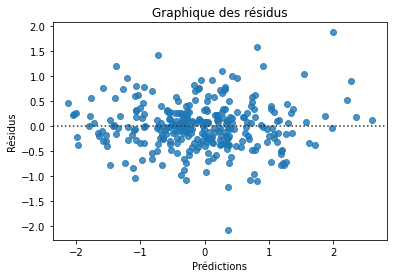

In [36]:
#On affine la recherche à partir des best_params de RandomizedSearchCV
params_RFR = {'n_estimators': [300, 350],
              'max_depth' : [12],
              'min_samples_split' : [2, 3, 4, 5],
              'min_samples_leaf' : [1],
              'max_features' : [None]}

#Le modèle
RFR_gridSearch = GridSearchCV(RandomForestRegressor(random_state=42), params_RFR, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
RFR_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_RFR = RFR_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_RFR = RFR_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = RFR_gridSearch.cv_results_
best_index = RFR_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_RFR)
train_MSE = mean_squared_error(y_train_scaled, y_train_RFR)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_RFR)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_RFR)
test_MSE = mean_squared_error(y_test_scaled, y_test_RFR)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_RFR)

#Impression des meilleurs paramètres
print("Best params :", RFR_gridSearch.best_params_)
print("Best estimator :", RFR_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['RandomForest', RFR_gridSearch.best_params_, RFR_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_RFR
sns.residplot(x=y_test_RFR, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

In [64]:
#Enfin, on termine par XGBRegressor()
#Encore une fois, beaucoup de paramètres à considérer alors on conserve la même stratégie
params_randomXGB = {'learning_rate' : np.arange(0.01, 0.21, 0.01), #Fourchette de 0.01 à 0.2 par pas de 0.01
                    'n_estimators' : np.arange(50, 501, 50), #Fourchette de 50 à 500 par pas de 50
                    'max_depth' : np.arange(3, 16, 1), #Fourchette de 3 à 15 par pas de 1
                    'min_child_weight' : np.arange(1, 6, 1), #Fourchette de 1 à 5 par pas de 1
                    'subsample' : np.arange(0.6, 1.01, 0.1), #Fourchette de 0.6 à 1.0 par pas de 0.1
                    'colsample_bytree' : np.arange(0.6, 1.01, 0.1)} #Fourchette de 0.6 à 1.0 par pas de 0.1

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomXGB_gridSearch = RandomizedSearchCV(XGBRegressor(), params_randomXGB, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomXGB_gridSearch.fit(X_train_oh, y_train_scaled)

    #Impression des meilleurs paramètres
    print("Best params :", randomXGB_gridSearch.best_params_)
    print("\n")

Best params : {'subsample': 0.8999999999999999, 'n_estimators': 250, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8999999999999999}


Best params : {'subsample': 0.6, 'n_estimators': 150, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.9999999999999999}


Best params : {'subsample': 0.7999999999999999, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.060000000000000005, 'colsample_bytree': 0.8999999999999999}


Best params : {'subsample': 0.7, 'n_estimators': 450, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.060000000000000005, 'colsample_bytree': 0.8999999999999999}


Best params : {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.08, 'colsample_bytree': 0.7}




In [65]:
#Comme avant, on ajuste certaines valeurs à tester
params_randomXGB = {'learning_rate' : [0.05, 0.06, 0.07, 0.08],
                    'n_estimators' : np.arange(100, 451, 50), #Fourchette de 100 à 450 par pas de 50
                    'max_depth' : [3, 4, 5],
                    'min_child_weight' : np.arange(1, 6, 1), #Fourchette de 1 à 5 par pas de 1
                    'subsample' : [0.6, 0.7, 0.8, 0.9],
                    'colsample_bytree' : [0.7, 0.8, 0.9, 1.0]}

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomXGB_gridSearch = RandomizedSearchCV(XGBRegressor(), params_randomXGB, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomXGB_gridSearch.fit(X_train_oh, y_train_scaled)

    #Impression des meilleurs paramètres
    print("Best params :", randomXGB_gridSearch.best_params_)
    print("\n")

Best params : {'subsample': 0.8, 'n_estimators': 350, 'min_child_weight': 4, 'max_depth': 3, 'learning_rate': 0.06, 'colsample_bytree': 0.8}


Best params : {'subsample': 0.6, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


Best params : {'subsample': 0.6, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.07, 'colsample_bytree': 0.9}


Best params : {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


Best params : {'subsample': 0.6, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.06, 'colsample_bytree': 0.7}




In [66]:
#Lentement mais sûrement, on lance une dernière fois
params_randomXGB = {'learning_rate' : [0.05, 0.06, 0.07],
                    'n_estimators' : [250, 300, 350],
                    'max_depth' : [3, 4],
                    'min_child_weight' : np.arange(1, 6, 1), #Fourchette de 1 à 5 par pas de 1
                    'subsample' : [0.6, 0.7, 0.8],
                    'colsample_bytree' : [0.7, 0.8, 0.9, 1.0]}

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomXGB_gridSearch = RandomizedSearchCV(XGBRegressor(), params_randomXGB, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomXGB_gridSearch.fit(X_train_oh, y_train_scaled)

    #Impression des meilleurs paramètres
    print("Best params :", randomXGB_gridSearch.best_params_)
    print("\n")

Best params : {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


Best params : {'subsample': 0.7, 'n_estimators': 350, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.07, 'colsample_bytree': 0.7}


Best params : {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.9}


Best params : {'subsample': 0.6, 'n_estimators': 350, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.06, 'colsample_bytree': 1.0}


Best params : {'subsample': 0.7, 'n_estimators': 350, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}




Best params : {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.7}
Best estimator : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Temps d'ajustement : 0.3145723342895508 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.1

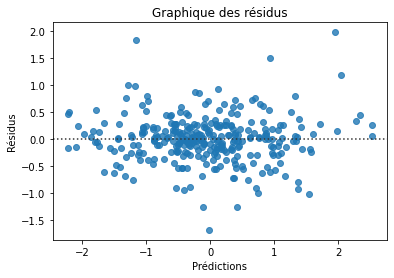

In [37]:
#On affine la recherche à partir des best_params de RandomizedSearchCV
params_XGB = {'learning_rate' : [0.05, 0.06, 0.07], 
              'n_estimators' : [300, 350],
              'max_depth' : [4],  
              'min_child_weight' : [1, 2, 3],  
              'subsample' : [0.6, 0.7],  
              'colsample_bytree' : [0.7, 0.8, 0.9, 1.0]}

#Le modèle
XGB_gridSearch = GridSearchCV(XGBRegressor(), params_XGB, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
XGB_gridSearch.fit(X_train_oh, y_train_scaled)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_XGB = XGB_gridSearch.predict(X_train_oh) #Jeu d'entraînement pour voir s'il y a overfit
y_test_XGB = XGB_gridSearch.predict(X_test_oh) #Jeu de test

#Résultats de la validation croisée
cv_results = XGB_gridSearch.cv_results_
best_index = XGB_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_scaled, y_train_XGB)
train_MSE = mean_squared_error(y_train_scaled, y_train_XGB)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_scaled, y_train_XGB)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_scaled, y_test_XGB)
test_MSE = mean_squared_error(y_test_scaled, y_test_XGB)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_scaled, y_test_XGB)

#Impression des meilleurs paramètres
print("Best params :", XGB_gridSearch.best_params_)
print("Best estimator :", XGB_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.append(['XGBoost', XGB_gridSearch.best_params_, XGB_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2])

#Pour visualiser les résidus
résidus = y_test_scaled - y_test_XGB
sns.residplot(x=y_test_XGB, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

In [38]:
#Pour y voir plus clair
résultats_gridSearch = pd.DataFrame(résultats_gridSearch, 
                                    columns=['Modèle', 'Best params', 'Best estimator', 'Fit time', 'Train MAE', 'Train MSE', 'Train RMSE', 'Train R²', 'Test MAE', 'Test MSE', 'Test RMSE', 'Test R²'])
résultats_gridSearch

,Modèle,Best params,Best estimator,Fit time,Train MAE,Train MSE,Train RMSE,Train R²,Test MAE,Test MSE,Test RMSE,Test R²
0,Ridge,"{'alpha': 500, 'solver': 'auto'}",Ridge(alpha=500),0.003,0.538,0.458,0.677,0.542,0.504,0.451,0.671,0.543
1,Lasso,"{'alpha': 0.1, 'max_iter': 1000, 'tol': 0.0001}",Lasso(alpha=0.1),0.010,0.593,0.545,0.738,0.455,0.564,0.540,0.735,0.452
2,ElasticNet,"{'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 10...","ElasticNet(alpha=0.1, max_iter=10000, tol=1e-08)",0.007,0.573,0.510,0.714,0.490,0.538,0.496,0.704,0.497
3,DecisionTree,"{'max_depth': 7, 'max_features': None, 'min_sa...","DecisionTreeRegressor(max_depth=7, min_samples...",0.008,0.317,0.168,0.410,0.832,0.414,0.293,0.541,0.703
4,SVR,"{'C': 1, 'epsilon': 0.2, 'gamma': 'scale', 'ke...","SVR(C=1, epsilon=0.2)",0.088,0.275,0.132,0.363,0.868,0.332,0.205,0.453,0.792
5,KernelRidge,"{'alpha': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","KernelRidge(alpha=0.01, gamma=0.01, kernel='rbf')",0.079,0.230,0.094,0.307,0.906,0.330,0.204,0.452,0.793
6,RandomForest,"{'max_depth': 12, 'max_features': None, 'min_s...","(DecisionTreeRegressor(max_depth=12, min_sampl...",2.616,0.181,0.055,0.234,0.945,0.349,0.224,0.473,0.773
7,XGBoost,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...","XGBRegressor(base_score=None, booster=None, ca...",0.315,0.200,0.069,0.263,0.931,0.306,0.187,0.433,0.810


Une nouvelle fois, XGBoost présente les meilleurs résultats sur le jeu de test.
# V) Choix du modèle et feature importance <a class="anchor" id="v"></a>

In [39]:
#On utilise les best_params
XGB = XGBRegressor(**XGB_gridSearch.best_params_)

#On fit
XGB.fit(X_train_oh, y_train_scaled)

#On predict
y_pred_XGB = XGB.predict(X_test_oh)

#Pour vérifier
MAE = mean_absolute_error(y_test_scaled, y_pred_XGB)
MSE = mean_squared_error(y_test_scaled, y_pred_XGB)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test_scaled, y_pred_XGB, multioutput="variance_weighted")
print("MAE =", MAE)        
print("MSE =", MSE)
print("RMSE =", RMSE)
print("R² =", R2)

MAE = 0.30625491494844725
MSE = 0.18714675844227957
RMSE = 0.43260462138340544
R² = 0.8101920176759558


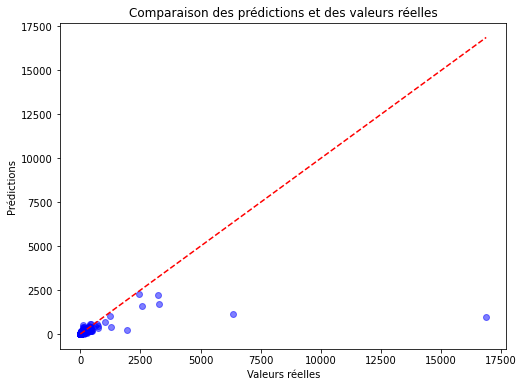

In [40]:
#Pour comparer les valeurs prédites et les valeurs réelles, inverse_transform le scaler
y_test_orig = scalery.inverse_transform(y_test_scaled.reshape(-1, 1))
y_pred_XGB_orig = scalery.inverse_transform(y_pred_XGB.reshape(-1, 1))

#Exponentielle pour revenir sur la transformation au log
y_test_orig = np.exp(y_test_orig)
y_pred_XGB_orig = np.exp(y_pred_XGB_orig)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred_XGB_orig, color='blue', alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], color='red', linestyle='--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Comparaison des prédictions et des valeurs réelles')
plt.show()

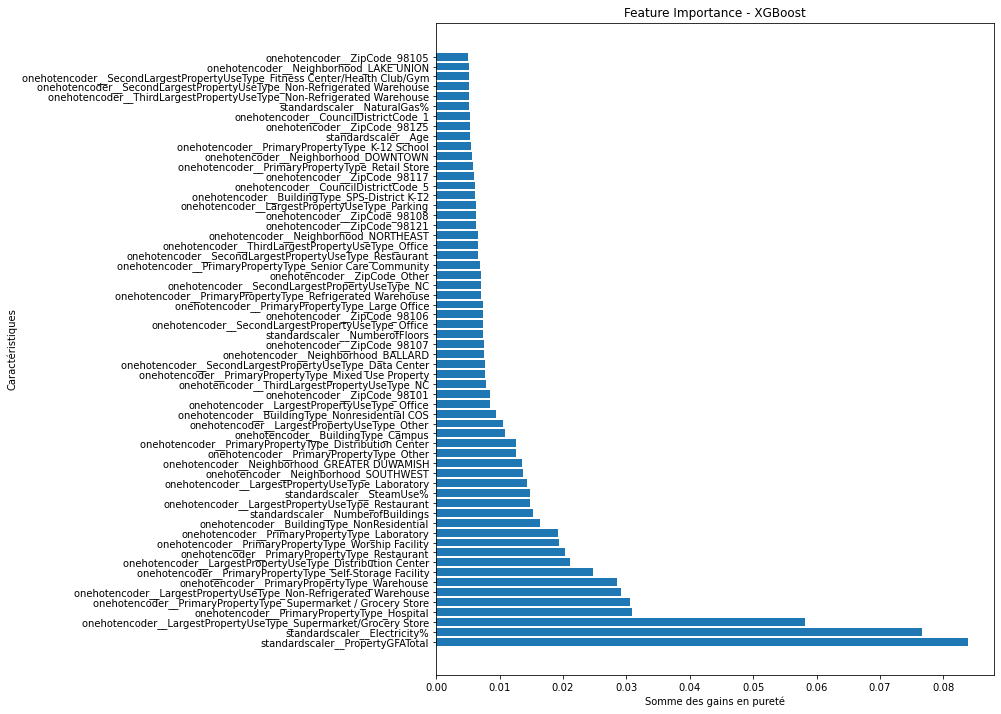

In [41]:
#On constate que les 2 valeurs les plus élevées sont très mal prédite, mais pas de souci pour le reste
#Pour visualiser la feature importance on a besoin de récupérer les noms des colonnes du one-hot encoder
noms_features_oh = preprocessor_oh.get_feature_names_out()

#On sélectionne le top 60
indices_rangés_XGB = np.argsort(XGB.feature_importances_)[::-1]
top_features = [noms_features_oh[i] for i in indices_rangés_XGB[:60]]
top_importances = [XGB.feature_importances_[i] for i in indices_rangés_XGB[:60]]

#On visualise
plt.figure(figsize=(10, 12))
plt.barh(top_features, top_importances)
plt.xlabel('Somme des gains en pureté')
plt.ylabel('Caractéristiques')
plt.title('Feature Importance - XGBoost')
plt.show()

Bien que PropertyGFATotal mène toujours la danse, le gain en pureté est plus équitablement partagé entre les variables que dans le précédent notebook. On en a bientôt fini avec ce projet, on cherche désormais à analyser l'influence d'ENERGYSTARScore qu'on a mis de côté plus tôt.
# VI) ENERGYSTARScore <a class="anchor" id="vi"></a>

In [42]:
#On ajoute ENERGYSTARScore à X
X['ENERGYSTARScore'] = ess
X

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,BuildingGFAperFloor,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,SteamUse%,Electricity%,NaturalGas%,ENERGYSTARScore
0,NonResidential,Hotel,98101,7,DOWNTOWN,89,1,12,88434,0,7369.500,Hotel,NC,NC,27.730,54.606,17.664,60
1,NonResidential,Hotel,98101,7,DOWNTOWN,20,1,11,103566,15064,8045.636,Hotel,Parking,Restaurant,0.000,38.661,61.339,61
2,NonResidential,Hotel,98101,7,DOWNTOWN,47,1,41,956110,196718,18521.756,Hotel,NC,NC,29.711,68.231,2.058,43
3,NonResidential,Hotel,98101,7,DOWNTOWN,90,1,10,61320,0,6132.000,Hotel,NC,NC,32.591,40.752,26.657,56
4,NonResidential,Hotel,98121,7,DOWNTOWN,36,1,18,175580,62000,6310.000,Hotel,Parking,Swimming Pool,0.000,37.880,62.120,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,Nonresidential COS,Other,98126,1,DELRIDGE,34,1,1,18261,0,18261.000,Other,NC,NC,0.000,67.844,32.156,<NA>
1541,Nonresidential COS,Other,98104,2,DOWNTOWN,12,1,1,16000,0,16000.000,Other,NC,NC,0.000,41.730,58.270,<NA>
1542,Nonresidential COS,Other,98119,7,MAGNOLIA / QUEEN ANNE,42,1,1,13157,0,13157.000,Other,Fitness Center/Health Club/Gym,Swimming Pool,0.000,31.082,68.918,<NA>
1543,Nonresidential COS,Mixed Use Property,98108,1,GREATER DUWAMISH,27,1,1,14101,0,14101.000,Other,Fitness Center/Health Club/Gym,Other,0.000,48.490,51.510,<NA>


In [43]:
#On filtre les valeurs manquantes
X_ess = X[X['ENERGYSTARScore'].notnull()]
y_ess = y[y.index.isin(list(X_ess.index))]

In [44]:
#On ajoute aux variables quantitatives pour les encoders
var_quanti_ess = var_quanti.append(pd.Index(['ENERGYSTARScore']))
var_quanti_ess

Index(['Age', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'BuildingGFAperFloor', 'SteamUse%',
       'Electricity%', 'NaturalGas%', 'ENERGYSTARScore'],
      dtype='object')

In [45]:
#Les encoders
preprocessor_oh_ess = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse=False), var_quali),
                                          (StandardScaler(), var_quanti_ess))

preprocessor_b_ess = make_column_transformer((BinaryEncoder(), var_quali), 
                                         (StandardScaler(), var_quanti_ess))

preprocessor_t_ess = make_column_transformer((TargetEncoder(), var_quali),
                                         (StandardScaler(), var_quanti_ess))

In [46]:
#On sépare jeu de test et jeu d'entraînement
X_train, X_test, y_train, y_test = train_test_split(X_ess, y_ess, test_size=0.2, random_state=0)
 
#Transformation des X
X_train_oh_ess = preprocessor_oh_ess.fit_transform(X_train)
X_test_oh_ess = preprocessor_oh_ess.transform(X_test)

X_train_b_ess = preprocessor_b_ess.fit_transform(X_train)
X_test_b_ess = preprocessor_b_ess.transform(X_test)

X_train_t_ess = preprocessor_t_ess.fit_transform(X_train, y_train)
X_test_t_ess = preprocessor_t_ess.transform(X_test)

#Transformation des y
y_train_ess = scalery.fit_transform(y_train.values.reshape(-1, 1)).flatten() #Pour un résultat unidimensionnel
y_test_ess = scalery.transform(y_test.values.reshape(-1, 1)).flatten() #Idem

In [47]:
#Encore une fois, les dimensions diffèrent d'un encodage à l'autre
print(X_train_oh_ess.shape)
print(X_train_b_ess.shape)
print(X_train_t_ess.shape)

(796, 120)
(796, 43)
(796, 18)


In [48]:
#On vérifie pour Target
noms_features_ess = np.concatenate((var_quali, var_quanti_ess))
pd.DataFrame(X_train_t_ess, columns=noms_features_ess)

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,BuildingGFAperFloor,SteamUse%,Electricity%,NaturalGas%,ENERGYSTARScore
0,4.020,3.067,3.951,3.771,3.803,3.100,3.724,3.919,-0.280,-0.096,-0.531,-0.455,-0.355,-0.052,-0.243,1.080,-0.990,0.975
1,4.020,3.355,3.896,3.742,4.119,4.069,4.065,3.919,-1.086,-0.096,-0.267,-0.420,-0.162,-0.370,-0.243,1.080,-0.990,-1.600
2,4.020,3.491,3.568,3.810,3.803,3.491,3.724,3.919,-0.466,-0.096,-0.399,-0.463,-0.355,-0.299,-0.243,-0.459,0.551,1.112
3,4.020,4.938,4.100,4.466,4.524,4.069,4.697,4.852,-0.714,-0.096,4.736,1.940,2.143,-0.339,-0.243,1.080,-0.990,0.700
4,4.020,3.355,4.491,4.466,4.119,4.069,4.224,3.919,0.308,-0.096,-0.399,-0.396,-0.355,-0.175,-0.243,0.626,-0.535,0.700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,4.020,3.355,4.100,4.466,4.524,4.069,3.724,3.919,1.950,-0.096,-0.267,-0.461,-0.355,-0.368,3.817,-0.864,-0.575,0.288
792,4.020,4.938,4.491,4.466,3.926,4.069,4.697,3.919,-1.024,0.991,-0.004,0.331,1.869,-0.206,-0.243,1.080,-0.990,0.666
793,4.020,4.085,4.100,4.319,4.441,4.207,3.917,4.852,-0.559,-0.096,-0.531,-0.491,-0.355,-0.185,-0.243,1.080,-0.990,-1.463
794,4.020,4.426,4.491,4.466,3.926,4.426,3.724,3.919,-0.218,-0.096,-0.399,-0.382,-0.355,-0.149,-0.243,-1.099,1.193,0.632


In [49]:
#On centre et réduit
X_train_t_ess[:, :8] = scalerx.fit_transform(X_train_t_ess[:, :8])
X_test_t_ess[:, :8] = scalerx.transform(X_test_t_ess[:, :8])
pd.DataFrame(X_train_t_ess, columns=noms_features_ess)

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Age,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,BuildingGFAperFloor,SteamUse%,Electricity%,NaturalGas%,ENERGYSTARScore
0,-0.152,-1.277,-0.261,-0.699,-0.670,-1.608,-0.757,-0.372,-0.280,-0.096,-0.531,-0.455,-0.355,-0.052,-0.243,1.080,-0.990,0.975
1,-0.152,-0.880,-0.379,-0.772,0.183,0.136,0.076,-0.372,-1.086,-0.096,-0.267,-0.420,-0.162,-0.370,-0.243,1.080,-0.990,-1.600
2,-0.152,-0.692,-1.086,-0.599,-0.670,-0.904,-0.757,-0.372,-0.466,-0.096,-0.399,-0.463,-0.355,-0.299,-0.243,-0.459,0.551,1.112
3,-0.152,1.305,0.058,1.066,1.281,0.136,1.619,3.049,-0.714,-0.096,4.736,1.940,2.143,-0.339,-0.243,1.080,-0.990,0.700
4,-0.152,-0.880,0.901,1.066,0.183,0.136,0.463,-0.372,0.308,-0.096,-0.399,-0.396,-0.355,-0.175,-0.243,0.626,-0.535,0.700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,-0.152,-0.880,0.058,1.066,1.281,0.136,-0.757,-0.372,1.950,-0.096,-0.267,-0.461,-0.355,-0.368,3.817,-0.864,-0.575,0.288
792,-0.152,1.305,0.901,1.066,-0.337,0.136,1.619,-0.372,-1.024,0.991,-0.004,0.331,1.869,-0.206,-0.243,1.080,-0.990,0.666
793,-0.152,0.127,0.058,0.693,1.056,0.384,-0.287,3.049,-0.559,-0.096,-0.531,-0.491,-0.355,-0.185,-0.243,1.080,-0.990,-1.463
794,-0.152,0.598,0.901,1.066,-0.337,0.779,-0.757,-0.372,-0.218,-0.096,-0.399,-0.382,-0.355,-0.149,-0.243,-1.099,1.193,0.632


In [50]:
#On teste les encoders, on va s'y prendre différemment car il n'y a qu'un seul modèle à tester
encoders_ess = {'OneHot': (X_train_oh_ess, X_test_oh_ess),
               'Binaire': (X_train_b_ess, X_test_b_ess),
               'Target': (X_train_t_ess, X_test_t_ess)}

#Pour enregistrer les résultats
résultats_ess = []

#Le modèle
XGBoost = XGBRegressor()

# Boucle sur les données pour chaque encodeur
for nom_encoder, (X_train, X_test) in encoders_ess.items():
    # On fit
    XGBoost.fit(X_train, y_train_ess)
    y_pred = XGBoost.predict(X_test)

    # Evaluation des performances
    print(f"Performance avec l'encodeur {nom_encoder} :")
    MAE = mean_absolute_error(y_test_ess, y_pred)
    MSE = mean_squared_error(y_test_ess, y_pred)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test_ess, y_pred, multioutput="variance_weighted")
    print("MAE =", MAE)
    print("MSE =", MSE)
    print("RMSE =", RMSE)
    print("R² =", R2)
    print("\n")

    # Ajout des résultats à la liste
    résultats_ess.append({'Encoder': nom_encoder, 'Modèle': 'XGBRegressor', 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE, 'R²': R2})

Performance avec l'encodeur OneHot :
MAE = 0.35142090032208345
MSE = 0.20633047486569467
RMSE = 0.4542361443849385
R² = 0.7826173778260178


Performance avec l'encodeur Binaire :
MAE = 0.3630873732947088
MSE = 0.2128052127596243
RMSE = 0.46130815379703
R² = 0.7757958188576306


Performance avec l'encodeur Target :
MAE = 0.3568317173431827
MSE = 0.22136258599609604
RMSE = 0.4704918553982588
R² = 0.7667800676251646




In [51]:
résultats_ess = pd.DataFrame(résultats_ess, columns=['Encoder', 'Modèle', 'MAE', 'MSE', 'RMSE', 'R²'])
résultats_ess

,Encoder,Modèle,MAE,MSE,RMSE,R²
0,OneHot,XGBRegressor,0.351,0.206,0.454,0.783
1,Binaire,XGBRegressor,0.363,0.213,0.461,0.776
2,Target,XGBRegressor,0.357,0.221,0.470,0.767


In [53]:
#Une nouvelle fois, c'est l'encodeur OneHot qui apporte les meilleurs résultats
#On comparera  ensuite les résultats obtenus avec ceux des du modèle retenu précédemment
params_randomXGB_ess = {'learning_rate' : np.arange(0.01, 0.21, 0.01), #Fourchette de 0.01 à 0.2 par pas de 0.01
                        'n_estimators' : np.arange(50, 501, 50), #Fourchette de 50 à 500 par pas de 50
                        'max_depth' : np.arange(3, 16, 1), #Fourchette de 3 à 15 par pas de 1
                        'min_child_weight' : np.arange(1, 6, 1), #Fourchette de 1 à 5 par pas de 1
                        'subsample' : np.arange(0.6, 1.01, 0.1), #Fourchette de 0.6 à 1.0 par pas de 0.1
                        'colsample_bytree' : np.arange(0.6, 1.01, 0.1)} #Fourchette de 0.6 à 1.0 par pas de 0.1

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomXGB_ess_gridSearch = RandomizedSearchCV(XGBRegressor(), params_randomXGB_ess, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomXGB_ess_gridSearch.fit(X_train_oh_ess, y_train_ess)

    #Impression des meilleurs paramètres
    print("Best params :", randomXGB_ess_gridSearch.best_params_)
    print("\n")

Best params : {'subsample': 0.6, 'n_estimators': 350, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.04, 'colsample_bytree': 0.9999999999999999}


Best params : {'subsample': 0.8999999999999999, 'n_estimators': 250, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


Best params : {'subsample': 0.7999999999999999, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.09, 'colsample_bytree': 0.9999999999999999}


Best params : {'subsample': 0.8999999999999999, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8999999999999999}


Best params : {'subsample': 0.7999999999999999, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.04, 'colsample_bytree': 0.7999999999999999}




In [56]:
#On progresse
params_randomXGB_ess = {'learning_rate' : np.arange(0.04, 0.1, 0.01), #Fourchette de 0.04 à 0.09 par pas de 0.01
                        'n_estimators' : np.arange(150, 351, 50), #Fourchette de 150 à 350 par pas de 50
                        'max_depth' : [3, 4, 5],
                        'min_child_weight' : [2, 3, 4, 5],
                        'subsample' : [0.6, 0.7, 0.8, 0.9],
                        'colsample_bytree' : np.arange(0.6, 1.01, 0.1)} #Fourchette de 0.6 à 1.0 par pas de 0.1

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomXGB_ess_gridSearch = RandomizedSearchCV(XGBRegressor(), params_randomXGB_ess, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomXGB_ess_gridSearch.fit(X_train_oh_ess, y_train_ess)

    #Impression des meilleurs paramètres
    print("Best params :", randomXGB_ess_gridSearch.best_params_)
    print("\n")

Best params : {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.07, 'colsample_bytree': 0.7999999999999999}


Best params : {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.07, 'colsample_bytree': 0.9999999999999999}


Best params : {'subsample': 0.7, 'n_estimators': 150, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.08000000000000002, 'colsample_bytree': 0.8999999999999999}


Best params : {'subsample': 0.6, 'n_estimators': 250, 'min_child_weight': 4, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.9999999999999999}


Best params : {'subsample': 0.7, 'n_estimators': 350, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.060000000000000005, 'colsample_bytree': 0.6}




In [57]:
#Une dernière fois, car il y a toujours pas mal d'incertitudes
params_randomXGB_ess = {'learning_rate' : [0.05, 0.06, 0.07, 0.08],
                        'n_estimators' : np.arange(150, 351, 50), #Fourchette de 150 à 350 par pas de 50
                        'max_depth' : [3, 4],
                        'min_child_weight' : [2],
                        'subsample' : [0.6, 0.7, 0.8],
                        'colsample_bytree' : np.arange(0.6, 1.01, 0.1)} #Fourchette de 0.6 à 1.0 par pas de 0.1

#On va le lancer plusieurs fois, pour être sûr
for i in range(5):
    #Le modèle
    randomXGB_ess_gridSearch = RandomizedSearchCV(XGBRegressor(), params_randomXGB_ess, scoring=scoring, refit='RMSE', n_iter=20, cv=5, n_jobs=5)

    #On fit
    randomXGB_ess_gridSearch.fit(X_train_oh_ess, y_train_ess)

    #Impression des meilleurs paramètres
    print("Best params :", randomXGB_ess_gridSearch.best_params_)
    print("\n")

Best params : {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.06, 'colsample_bytree': 0.7}


Best params : {'subsample': 0.6, 'n_estimators': 250, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7999999999999999}


Best params : {'subsample': 0.6, 'n_estimators': 150, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.08, 'colsample_bytree': 0.7999999999999999}


Best params : {'subsample': 0.6, 'n_estimators': 250, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.08, 'colsample_bytree': 0.7999999999999999}


Best params : {'subsample': 0.6, 'n_estimators': 150, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.08, 'colsample_bytree': 0.7999999999999999}




Best params : {'colsample_bytree': 0.8, 'learning_rate': 0.06, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6}
Best estimator : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Temps d'ajustement : 0.19151692390441893 secondes


Métriques sur le jeu d'entraînement :
Test MAE : 0.

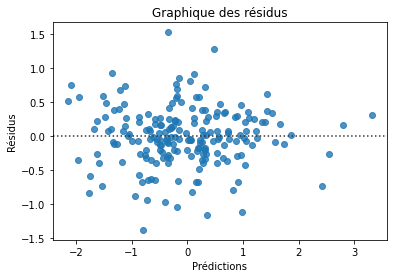

In [58]:
#On affine la recherche à partir des best_params de RandomizedSearchCV
params_ess_XGB = {'learning_rate' : [0.05, 0.06, 0.07, 0.08],
                  'n_estimators' : np.arange(150, 301, 50), #Fourchette de 150 à 300 par pas de 50
                  'max_depth' : [3],
                  'min_child_weight' : [2],
                  'subsample' : [0.6],
                  'colsample_bytree' : [0.8]}

#Le modèle
XGB_ess_gridSearch = GridSearchCV(XGBRegressor(), params_ess_XGB, scoring=scoring, refit='RMSE', cv=5, n_jobs=5)

#On fit
XGB_ess_gridSearch.fit(X_train_oh_ess, y_train_ess)

#On predict
#GridSearchCV enregistre automatiquement les meilleurs paramètres identifiés lors de la recherche
y_train_XGB_ess = XGB_ess_gridSearch.predict(X_train_oh_ess) #Jeu d'entraînement pour voir s'il y a overfit
y_test_XGB_ess = XGB_ess_gridSearch.predict(X_test_oh_ess) #Jeu de test

#Résultats de la validation croisée
cv_results = XGB_ess_gridSearch.cv_results_
best_index = XGB_ess_gridSearch.best_index_

#Temps d'ajustement
fit_time = cv_results['mean_fit_time'][best_index]

#Métriques sur le jeu d'entraînement
train_MAE = mean_absolute_error(y_train_ess, y_train_XGB_ess)
train_MSE = mean_squared_error(y_train_ess, y_train_XGB_ess)
train_RMSE = np.sqrt(train_MSE)
train_R2 = r2_score(y_train_ess, y_train_XGB_ess)

#Métriques à partir des prédictions
test_MAE = mean_absolute_error(y_test_ess, y_test_XGB_ess)
test_MSE = mean_squared_error(y_test_ess, y_test_XGB_ess)
test_RMSE = np.sqrt(test_MSE)
test_R2 = r2_score(y_test_ess, y_test_XGB_ess)

#Impression des meilleurs paramètres
print("Best params :", XGB_ess_gridSearch.best_params_)
print("Best estimator :", XGB_ess_gridSearch.best_estimator_)
print("Temps d'ajustement :", fit_time, "secondes")
print("\n")

#Impression des métriques sur le jeu d'entraînement
print("Métriques sur le jeu d'entraînement :")
print("Test MAE :", train_MAE)
print("Test MSE :", train_MSE)
print("Test RMSE :", train_RMSE)
print("Test R² :", train_R2)
print("\n")

#Impression des métriques à partir des prédictions
print("Métriques à partir des prédictions :")
print("Test MAE :", test_MAE)
print("Test MSE :", test_MSE)
print("Test RMSE :", test_RMSE)
print("Test R² :", test_R2)

#On ajoute les résultats à la liste
résultats_gridSearch.loc[len(résultats_gridSearch)] = ['XGBoost_ESS', XGB_ess_gridSearch.best_params_, XGB_ess_gridSearch.best_estimator_, fit_time,
                             train_MAE, train_MSE, train_RMSE, train_R2, test_MAE, test_MSE, test_RMSE, test_R2]

#Pour visualiser les résidus
résidus = y_test_ess - y_test_XGB_ess
sns.residplot(x=y_test_XGB_ess, y=résidus)
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')

plt.show()

In [59]:
résultats_gridSearch

,Modèle,Best params,Best estimator,Fit time,Train MAE,Train MSE,Train RMSE,Train R²,Test MAE,Test MSE,Test RMSE,Test R²
0,Ridge,"{'alpha': 500, 'solver': 'auto'}",Ridge(alpha=500),0.003,0.538,0.458,0.677,0.542,0.504,0.451,0.671,0.543
1,Lasso,"{'alpha': 0.1, 'max_iter': 1000, 'tol': 0.0001}",Lasso(alpha=0.1),0.010,0.593,0.545,0.738,0.455,0.564,0.540,0.735,0.452
2,ElasticNet,"{'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 10...","ElasticNet(alpha=0.1, max_iter=10000, tol=1e-08)",0.007,0.573,0.510,0.714,0.490,0.538,0.496,0.704,0.497
3,DecisionTree,"{'max_depth': 7, 'max_features': None, 'min_sa...","DecisionTreeRegressor(max_depth=7, min_samples...",0.008,0.317,0.168,0.410,0.832,0.414,0.293,0.541,0.703
4,SVR,"{'C': 1, 'epsilon': 0.2, 'gamma': 'scale', 'ke...","SVR(C=1, epsilon=0.2)",0.088,0.275,0.132,0.363,0.868,0.332,0.205,0.453,0.792
5,KernelRidge,"{'alpha': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","KernelRidge(alpha=0.01, gamma=0.01, kernel='rbf')",0.079,0.230,0.094,0.307,0.906,0.330,0.204,0.452,0.793
6,RandomForest,"{'max_depth': 12, 'max_features': None, 'min_s...","(DecisionTreeRegressor(max_depth=12, min_sampl...",2.616,0.181,0.055,0.234,0.945,0.349,0.224,0.473,0.773
7,XGBoost,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...","XGBRegressor(base_score=None, booster=None, ca...",0.315,0.200,0.069,0.263,0.931,0.306,0.187,0.433,0.810
8,XGBoost_ESS,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...","XGBRegressor(base_score=None, booster=None, ca...",0.192,0.189,0.059,0.244,0.941,0.326,0.191,0.437,0.798


In [60]:
#Peu de changement, les métriques d'entraînement sont légèrement meilleures, celles de test légèrement moins bonnes
#On cherche désormais à déterminer l'importance d'ENERGYSTARScore
XGB_ess = XGBRegressor(**XGB_ess_gridSearch.best_params_)

#On fit
XGB_ess.fit(X_train_oh_ess, y_train_ess)

#On predict
y_pred_XGB_ess = XGB_ess.predict(X_test_oh_ess)

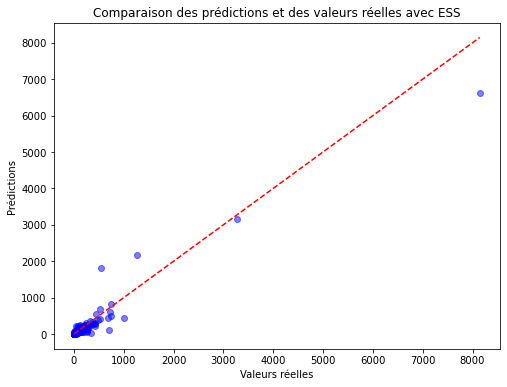

In [61]:
#Pour comparer les valeurs prédites et les valeurs réelles, inverse_transform le scaler
y_test_ess_orig = scalery.inverse_transform(y_test_ess.reshape(-1, 1))
y_pred_XGB_ess_orig = scalery.inverse_transform(y_pred_XGB_ess.reshape(-1, 1))

#Exponentielle pour revenir sur la transformation au log
y_test_ess_orig = np.exp(y_test_ess_orig)
y_pred_XGB_ess_orig = np.exp(y_pred_XGB_ess_orig)

plt.figure(figsize=(8, 6))
plt.scatter(y_test_ess_orig, y_pred_XGB_ess_orig, color='blue', alpha=0.5)
plt.plot([y_test_ess_orig.min(), y_test_ess_orig.max()], [y_test_ess_orig.min(), y_test_ess_orig.max()], color='red', linestyle='--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Comparaison des prédictions et des valeurs réelles avec ESS')
plt.show()

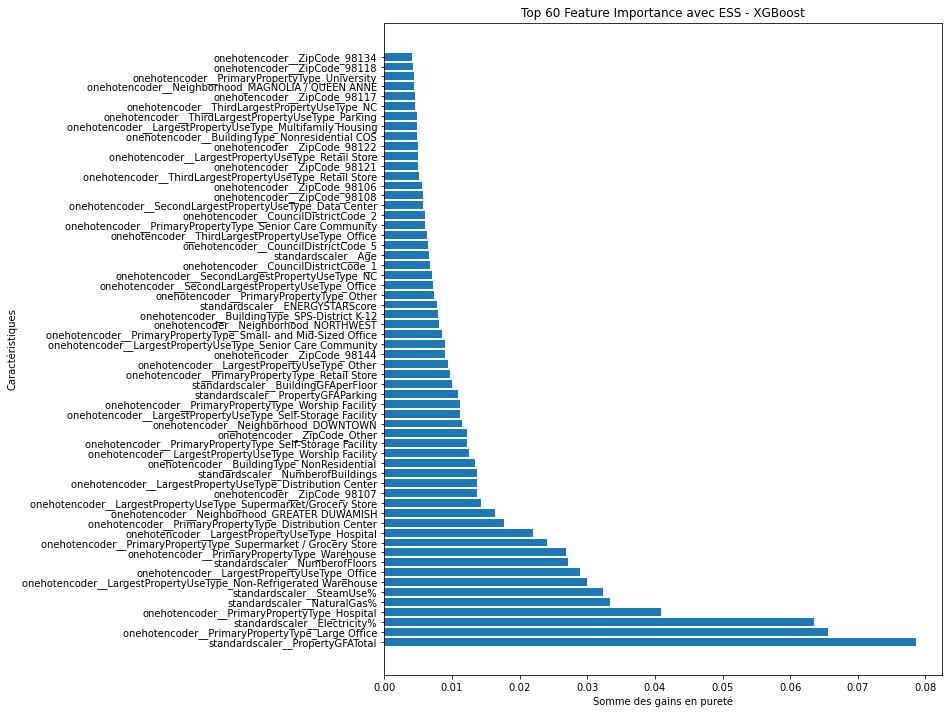

In [63]:
#A l'exception de la valeur la plus élevée, les prédictions semblent très bonnes
#Pour visualiser la feature importance on a besoin de récupérer les noms des colonnes du one-hot encoder
noms_features_oh_ess = preprocessor_oh_ess.get_feature_names_out()

#Il y en a beaucoup alors on ne va afficher que le top 60
indices_rangés_XGB_ess = np.argsort(XGB_ess.feature_importances_)[::-1]
top_features_ess = [noms_features_oh_ess[i] for i in indices_rangés_XGB_ess[:60]]
top_importances_ess = [XGB_ess.feature_importances_[i] for i in indices_rangés_XGB_ess[:60]]

#On visualise
plt.figure(figsize=(10, 12))
plt.barh(top_features_ess, top_importances_ess)
plt.xlabel('Somme des gains en pureté')
plt.ylabel('Caractéristiques')
plt.title('Top 60 Feature Importance avec ESS - XGBoost')
plt.show()

L'ENERGYSTARScore se retrouve en milieu de top 60 et semble avoir un poids moyen.
# Conclusion <a class="anchor" id="conclusion"></a>
XGBoost est à nouveau le meilleur modèle pour prédire les émissions des bâtiments en se basant exclusivement sur leurs données structurelles. Les résultats sont légèrement meilleurs que ceux du notebook précédent. En effet, si TotalGHGEmissions est moins fortement corrélée à ces données structurelles que ne l'est SiteEnergyUse, les variables relatives à la nature et la proportion des sources d'énergies semblent avoir apporté beaucoup de poids en terme de prédiction de cette cible.

Dans ce contexte, l'inclusion d'ENERGYSTARScore semble ne pas avoir d'effet notable sur la qualité des prédictions. Encore une fois, l'ajout de cette feature nous a contraint à réduire la taille du jeu de données et donc, à perdre de l'information.

En somme, il est possible d'aboutir à une approximation cohérente des émissions de CO2 et de la consommation totale d'énergie de bâtiments non destinés à l'habitation sans avoir nécessairement besoin des relevés. Il ne semble pas que l'ajout d'ENERGYSTARScore apporte une réelle plus-value aux prédictions, si elle doit s'accompagner d'une réduction de la taille du jeu de données.

On note cependant une perte de précision lorsqu'on cherche à prédire les valeurs les plus élevées. En effet, celles-ci étant plus rares dans le jeu de données, le modèle n'est pas aussi performant.